<a href="https://colab.research.google.com/github/ImSittingOnSalt/Pizza-or-not/blob/main/Neuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
from PIL import Image
import os
import pathlib
import matplotlib.pyplot as plt
from os import listdir

import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
import visualkeras

import base64
import cv2


random.seed(1)
np.random.seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/pizza_not_pizza/pizza/'
images = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        img = Image.open(os.path.join(folder_path, file_name))
        images.append(img)

Mounted at /content/drive


In [ ]:
# Получаю имена классов
data_dir = pathlib.Path('/content/drive/My Drive/pizza_not_pizza/')
class_names = [item.name for item in data_dir.glob('*')][:2]
print(class_names)

['pizza', 'not_pizza']


In [ ]:
pizza_dir = '/content/drive/My Drive/pizza_not_pizza/pizza/'         #дирректории классов
not_pizza_dir = '/content/drive/My Drive/pizza_not_pizza/not_pizza/'

len_pizza_img = len(os.listdir(pizza_dir))          #сколько фотов пицы......
len_not_pizza_img = len(os.listdir(not_pizza_dir))
print(len_pizza_img, len_not_pizza_img)

983 983


In [ ]:
# Разделение на тренировочный и валидационный наборы
not_pizza = [(os.path.join(not_pizza_dir, image), 0) for image in os.listdir(os.path.join(not_pizza_dir)) if image.split(".")[1] == "jpg"]
pizza     = [(os.path.join(pizza_dir,     image), 1) for image in os.listdir(os.path.join(pizza_dir))     if image.split(".")[1] == "jpg"]

df = pd.DataFrame(not_pizza+pizza,columns=['filename','category'])
df.sample()

train_df,dummy_df = train_test_split(df,train_size=0.7,random_state=42,shuffle=True)
val_df,test_df = train_test_split(dummy_df,train_size=0.6,random_state=42,shuffle=True)

train_df.category = train_df.category.astype(str)
val_df.category = val_df.category.astype(str)
test_df.category = test_df.category.astype(str)

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_dataframe(train_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)
val_generator   = datagen.flow_from_dataframe(val_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)
test_generator  = datagen.flow_from_dataframe(test_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)

Found 1376 validated image filenames belonging to 2 classes.
Found 354 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Заморозить слои базовой модели
for layer in base_model.layers:
    layer.trainable = False

# Создание модели Keras
model = Sequential()
model.add(base_model)
model.add(GlobalAvgPool2D())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

# Компиляция модели (при использовании оптимизаторов и функций потерь TensorFlow)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 4s 0us/step


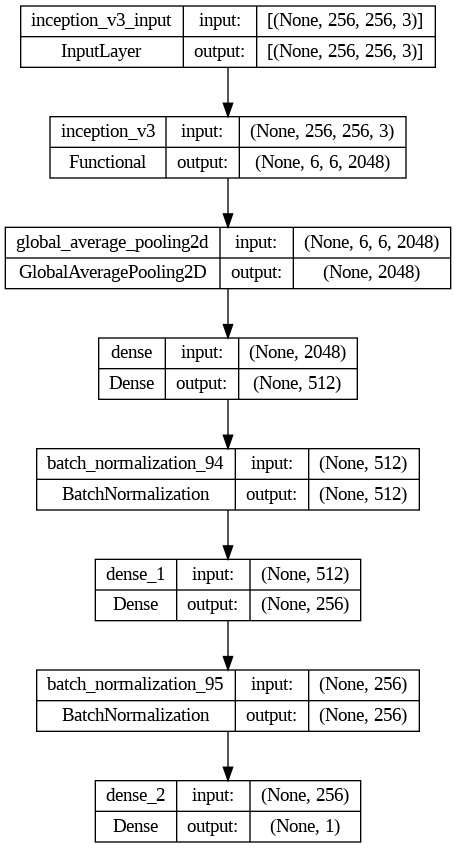

In [ ]:
plot_model(model,show_layer_names=True,show_shapes=True)

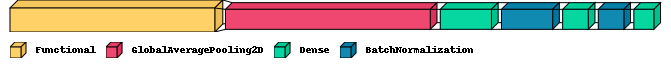

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
modelcheck = ModelCheckpoint(filepath='/content/drive/My Drive/model.h5',monitor='val_loss',save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs')

In [ ]:
history = model.fit(train_generator,validation_data=val_generator,epochs=20,callbacks=[modelcheck,earlystop,tensorboard])

Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9172

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 326s 7s/step - loss: 0.2268 - accuracy: 0.9172 - val_loss: 0.3103 - val_accuracy: 0.9096
Epoch 2/20
43/43 [==============================] - 310s 7s/step - loss: 0.1005 - accuracy: 0.9629 - val_loss: 0.2050 - val_accuracy: 0.9379
Epoch 3/20
43/43 [==============================] - 334s 8s/step - loss: 0.1005 - accuracy: 0.9578 - val_loss: 0.1360 - val_accuracy: 0.9435
Epoch 4/20
43/43 [==============================] - 330s 8s/step - loss: 0.0740 - accuracy: 0.9680 - val_loss: 0.1321 - val_accuracy: 0.9633
Epoch 5/20
43/43 [==============================] - 316s 7s/step - loss: 0.0793 - accuracy: 0.9709 - val_loss: 0.1481 - val_accuracy: 0.9492
Epoch 6/20
43/43 [==============================] - 329s 8s/step - loss: 0.0704 - accuracy: 0.9724 - val_loss: 0.0978 - val_accuracy: 0.9633
Epoch 7/20
43/43 [==============================] - 305s 7s/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 0.1971 - val_accuracy: 0.9350
Epoch 8/20
43/43 [======

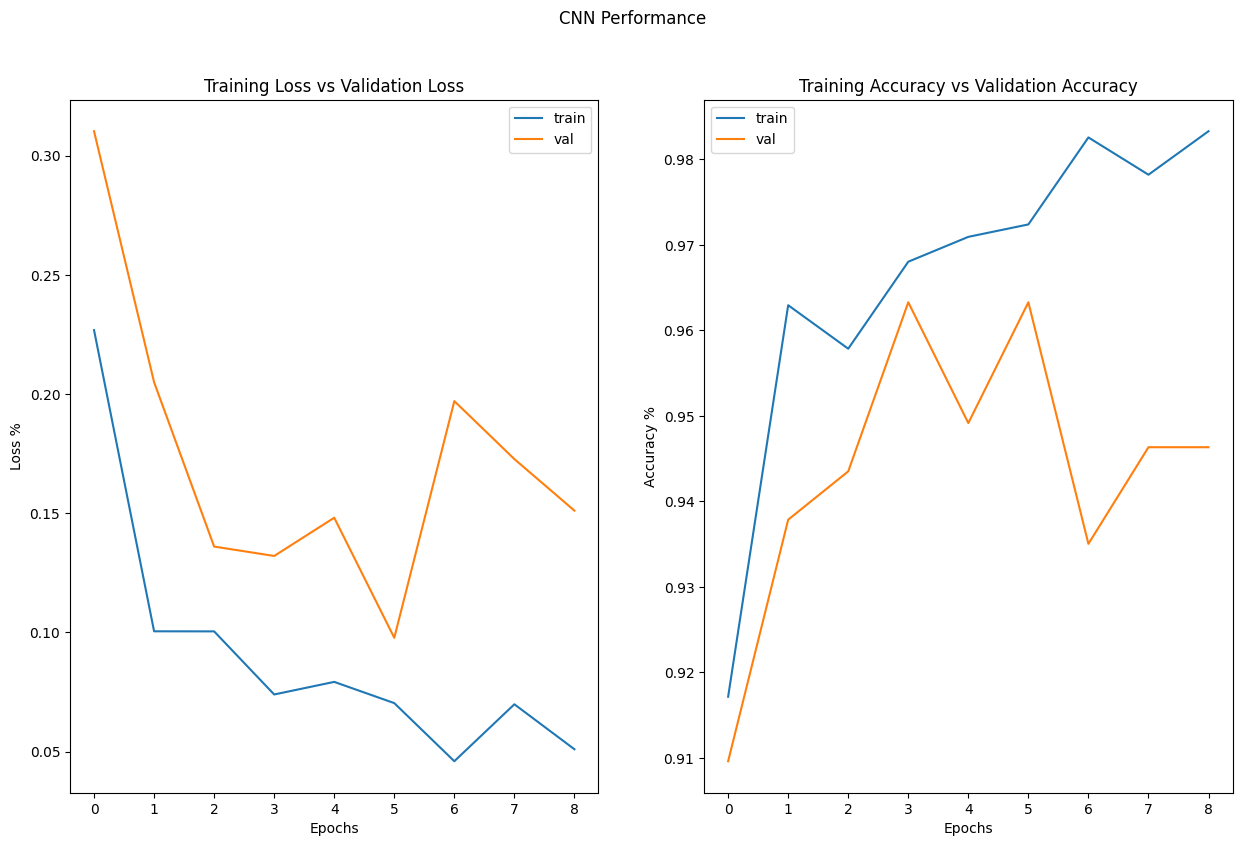

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,9))
total_epochs = [i for i in range(len(history.history['loss']))]
fig.suptitle("CNN Performance")

ax[0].plot(total_epochs,history.history['loss'],label='train')
ax[0].plot(total_epochs,history.history['val_loss'],label='val')
ax[0].set_title("Training Loss vs Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss %")
ax[0].legend(loc='best')

ax[1].plot(total_epochs,history.history['accuracy'],label='train')
ax[1].plot(total_epochs,history.history['val_accuracy'],label='val')
ax[1].set_title("Training Accuracy vs Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy %")
ax[1].legend(loc='best')
plt.show()

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
loss,acc = model.evaluate_generator(train_generator)
print(f'Training loss={loss}, Accuracy={acc}')

loss,acc = model.evaluate_generator(val_generator)
print(f'Validation loss={loss}, Accuracy={acc}')

loss,acc = model.evaluate_generator(test_generator)
print(f'Test loss={loss}, Accuracy={acc}')

<ipython-input-17-d97dda758d11>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss,acc = model.evaluate_generator(train_generator)


Training loss=0.03550522401928902, Accuracy=0.9869186282157898


<ipython-input-17-d97dda758d11>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss,acc = model.evaluate_generator(val_generator)


Validation loss=0.10865806043148041, Accuracy=0.9604519605636597


<ipython-input-17-d97dda758d11>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss,acc = model.evaluate_generator(test_generator)


Test loss=0.19163711369037628, Accuracy=0.9279661178588867


<ipython-input-18-6e0cb7e93bb2>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


1/1 [==============================] - 0s 165ms/step


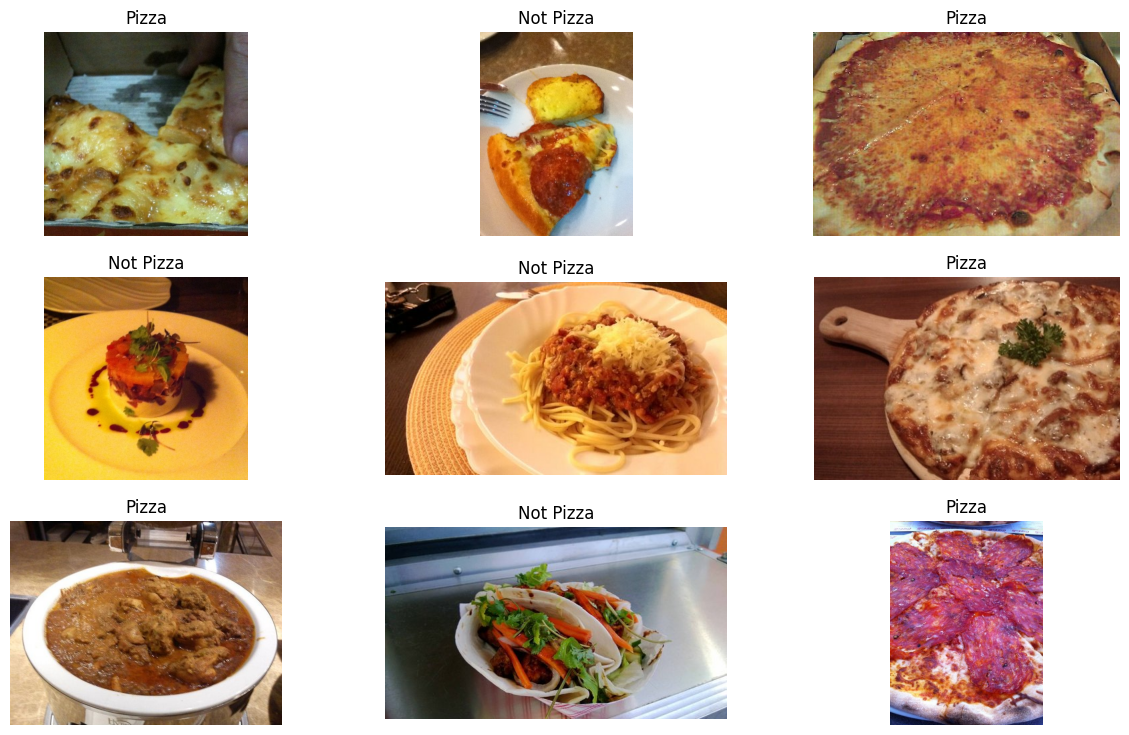

In [ ]:
import cv2
sample_images = test_df.sample(n=9)
class_names = [item.name for item in data_dir.glob('*')][:2]
figure,ax = plt.subplots(figsize=(15,9))
for i,image in enumerate(sample_images.filename):
    plt.subplot(3,3,i+1)
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.axis('off')
    img = cv2.resize(img,(256,256))
    img = np.expand_dims(img,axis=0)
    img = img.astype('float32')
    img = datagen.standardize(img)
    y_pred=model.predict(img)
    if y_pred>0.5:
        plt.title('Pizza')
    else:
        plt.title("Not Pizza")
plt.show()

In [ ]:
sample_images

,filename,category
1787,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
1432,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
1605,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
307,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
450,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
994,/content/drive/My Drive/pizza_not_pizza/pizza/...,1
874,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
887,/content/drive/My Drive/pizza_not_pizza/not_pi...,0
1798,/content/drive/My Drive/pizza_not_pizza/pizza/...,1


In [ ]:
preds=model.predict_generator(test_generator)

<ipython-input-20-98bcd331680f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds=model.predict_generator(test_generator)


In [ ]:
y_pred = [1 if i>0.5 else 0 for i in preds]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.5720338983050848


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       118
           1       0.57      0.58      0.58       118

    accuracy                           0.57       236
   macro avg       0.57      0.57      0.57       236
weighted avg       0.57      0.57      0.57       236



In [ ]:
model.save('/content/drive/My Drive/last_model.h5')
# model.save('/content/drive/My Drive/my_model.h5') # сюда сохранять только если эта модель лучше прошлых

In [ ]:
import telebot
import cv2
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Загружаем модель машинного обучения
model = tf.keras.models.load_model('/content/drive/My Drive/my_model.h5')
datagen = ImageDataGenerator(rescale=1./255)

# Создаем бота TeleBot
bot = telebot.TeleBot('7169479433:AAGJY4uLCJL_T_14pFdTcO5p-MEQrr9akyY')

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    bot.send_message(message.chat.id, 'Приветствую в пицца-боте! Отправьте фото, чтобы узнать, есть ли на нем пицца.')

# Обработчик фото
@bot.message_handler(content_types=['photo'])
def predict(message):
    # Получаем фото из сообщения
    photo_file = message.photo[-1]
    file_id = photo_file.file_id

    # Скачиваем фото
    try:
        file_info = bot.get_file(file_id)
        downloaded_file = bot.download_file(file_info.file_path)
    except Exception as e:
        print(f'Ошибка при скачивании фото: {e}')
        return

    # Преобразуем скачанное фото в массив NumPy
    image = np.fromstring(downloaded_file, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Предобработка изображения
    image = cv2.resize(image, (256, 256))
    image = Image.fromarray(image)
    image = np.array(image)
    image = image.astype('float32')
    image = datagen.standardize(np.expand_dims(image, axis=0))

    # Предсказание модели
    y_pred = model.predict(image)
    pizza_probability = y_pred[0][0]

    # Формирование ответа
    if pizza_probability > 0.5:
        response = f"На этом фото, скорее всего, пицца! (Вероятность: {pizza_probability:.2f})"
    else:
        response = f"На этом фото, скорее всего, не пицца. (Вероятность: {pizza_probability:.2f})"

    # Отправляем ответ
    bot.send_message(message.chat.id, response)

# Запускаем бота
bot.polling()

<ipython-input-34-23898f265970>:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(downloaded_file, dtype=np.uint8)


1/1 [==============================] - 0s 158ms/step
